In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.sparse
import scipy.linalg
import tensorflow as tf
import tensorflow_probability as tfp

2024-07-20 15:35:54.762791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Inverse Problem
Given parameters of interest (PoI) and observation of a state variable, consider the folowing additive noise model
$$
\textbf{y} = F(\textbf{u}) + \textbf{e}
$$
where $\textbf{u}$ are the PoI, $F$ is the parameter-to-observable(Pto) map and $\textbf{y}$ represent observational data.  

__Goal:__ determine the parameter of interest $\textbf{u}$ given the observational data $\textbf{y}$.  

Solving the inverse problem usually involves solving an optimization problem of the form
$$
\min_{\textbf{u}} \lVert \textbf{y} - F(\textbf{u}) \rVert_{2}^2 + R(\textbf{u})
$$
where $ R(\textbf{u})$ is a regularization term to reduce the size of the solution space, since the problem is usually ill-posed (many possible solution exist that are coherent with our data).  

__Problem:__ the optimization of such functional is computationally expansive.  

__Solution:__ learning a data-driven solver that after an offline training stage (expansive but done only one time), output estimate of our PoI.  

Given as training set  $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$, if we use a neural network $\Psi$ then our solver is paramerized by the weight of the network $\textbf{W}$. This solver require the optimization of the following functional
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \lVert \textbf{u}^{(m)} - \Psi(\textbf{y}^{(m)}, \textbf{W}) \rVert_{2}^2 + R(\textbf{W})
$$

Instead of regularize the weight of the network directly, we can regularize the output of the network, informing the optimization procedure of the inversion task, of the properties of the noise afflicting our observational data and the knowledge about some physical properties of the PoI we posses. This lead to the following optimization objective
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \lVert \textbf{u}^{(m)} - \Psi(\textbf{y}^{(m)}, \textbf{W}) \rVert_{2}^2 + \lVert M (\textbf{y} - F(\Psi(\textbf{y}^{(m)}, \textbf{W}))) \rVert_{2}^2 + \lVert P (\Psi(\textbf{y}^{(m)}, \textbf{W})) \rVert_{2}^2
$$
where $M,P$ are some mapping representing information about noise and PoI respectively.

# Bayesian Inverse Problem
By adopting a probabilisitc framework instead of deterministic, the question asked by the inverse problem essentially changes from “what is the value of our parameter?” to “how accurate is the estimate of our parameter?”.   

In this setting, inverse problem deal with the following observational model
$$
    Y = F(U) + E
$$
where $F$ is __Parameter-to-Observable(PtO)__ map and $Y,U,E$ are random variable representing respectively the observational data, the __Parameters of Intereste(PoI)__ and the noise model.  

 

__Goal:__ model the posterior distribution $P(\textbf{u} | \textbf{y})$, i.e "given the observational data, what is the distribution of the parameters of interest?"

Using Bayes' Theorem
$$
P(\textbf{u} | \textbf{y}) \propto P(\textbf{y} | \textbf{u})P(\textbf{u})
$$
The assumptions usually made are:
- $E \sim N(\mu_E, \Gamma_E)$, $U \sim N(\mu_{pr}, \Gamma_{pr})$, $E\perp U$
- $ P(\textbf{y} | \textbf{u}) = P_E (\textbf{y} - F(\textbf{u}))$


__Problem:__ computing such probability is often intractable.  

__Solution:__ using variational inference to approximate such distributions.

Denoting by  $P(\textbf{u} | \textbf{y})$ the target posterior density we want to approximate, __variational inference__ perform such approximation choosing a set of probability distributin $Q_{\phi}(\textbf{u} | \textbf{y})$ parameterized by a parameter $\phi$ and then finiding the distribution in such family "closest" to the target one.  

To do that some notion of distance between $Q_{\phi}(\textbf{u} | \textbf{y})$ and $P(\textbf{u} | \textbf{y})$ must be introduced.  

Normally the Kullback-Leibler divergence (KLD) is used to obtain the evidence lower bound (ELBO), an useful lower bound on the log-likelihood of some observed data, and the goal of variational inference is to minimize the KL divergence, or, equivalently, maximizing the evidence lower bound (ELBO).

Following the work in the reference [1], instead of KLD, a family of Jensen-Shannon Divergence (JSD) is used, leading to the minimization of the following quantity
$$
\frac{1-\alpha}{\alpha} KL(P(\textbf{u} | \textbf{y}) | Q_{\phi}\textbf{u} | \textbf{y})) - \mathbb{E}_{\textbf{u} \sim Q_{\phi}} \left[ \log(P(\textbf{y} | \textbf{u})) \right] + KL(Q_{\phi}(\textbf{u} | \textbf{y}) |P(\textbf{u}))
$$
where $KL(\cdot,\cdot)$ denote the Kullback-Leibler divergence.  

__Objective:__  incorporate such minimization problem into a deep learning framework, i.e recave a differentiable loss function in the form of the one written above in the deterministic setting to train a neural network to perform the variational inference task. 

To do so:
- consider a training set  $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$
- apply the fact that the minimization of the KLD between the empirical and model distributions is equivalent to maximization of the likelihood function with respect to $\phi$.
- form a Monte-Carlo estimation using our PoI data
- adopt a Gaussian model for our model posterior $Q_{\phi}(\textbf{u} | \textbf{y}^{(m)})= N(\textbf{u} | \mu_{post}^{(m)}, \Gamma_{post}^{(m)})$
- adopt the Gaussian prior distribution for the noise and the PoI model as assumed above

Detail are in the reference [1].

Considering a neural network $\Psi$ with paramters $\textbf{W}$ that takes as input our observation data $\textbf{y}^{(m)}$ and output the statistics of our approximated posterior model $\phi^{(m)} = (\mu_{post}^{(m)}, \Gamma_{post}^{(m)})$, the following loss function is obtained:
$$
\min_{\textbf{W}} \frac{1}{M} \sum_{m=1}^M \frac{1-\alpha}{\alpha} (\log |\Gamma_{post}^{(m)}| + \lVert \mu_{post}^{(m)}- \textbf{u}^{(m)}) \rVert_{\Gamma_{post}^{(m)-1}}^2 
$$

$$
    + \lVert \textbf{y}^{(m)} - F(\textbf{u}_{draw}^{(m)}(\textbf{W})) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2 
$$

$$
     + \text{tr}(\Gamma_{pr}^{-1}\Gamma_{post}^{(m)}) +   \lVert \mu_{post}^{(m)}- \textbf{u}_{(pr)}) \rVert_{\Gamma_{pr}^{-1}}^2 + \log \frac{\Gamma_{pr}}{\Gamma_{post}^{(m)}}
$$
where
$$
    (\mu_{post}^{(m)}, \Gamma_{post}^{\frac{1}{2}(m)}) = \Psi (\textbf{y}^{(m)}, \textbf{W})
$$

$$
    \textbf{u}_{draw}^{(m)}(\textbf{W}) = \mu_{post}^{(m)} + \Gamma_{post}^{\frac{1}{2}(m)} \epsilon
$$

$$
    \epsilon \sim N(0, \textbf{I}_D)
$$

During the training procedure, the repeated operation of the PtO map on our dataset $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$ may incur a significant computational cost. To alleviate this the PtO map is replaced with another neural network $\Psi_d$ parameterized by weights $\textbf{W}_d$. This is reflected in the following modification of the loss function


$$
     \lVert \textbf{y}^{(m)} - F(\textbf{u}_{draw}^{(m)}(\textbf{W})) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2  \rightarrow \lVert \textbf{y}^{(m)} - \Psi_d(\textbf{u}_{draw}^{(m)}(\textbf{W}), \textbf{W}_d) - \mu_E \rVert_{\Gamma_{E}^{-1}}^2
$$

As exaplained in the paragraph below, our loss function is regularized by the likelihood model containing the PtO map and the prior model containing information on our PoI space.
![](./assets/UQ-VAE.jpeg)

# Test

## Poisson Problem
Consider the following modification of Diriclet problem for the poisson equation in two dimension, $\textbf{x} = (x,y) \in \Omega = (0,1)^2$:
$$
\begin{cases}
    - \nabla (q(\textbf{x})\cdot \nabla y(\textbf{x})) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    y(\textbf{x}) = 0 \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
where $q(\textbf{x})$ is the conductivity coefficent, our parameter of interest (with previous notation $\textbf{u} := q(\textbf{x})) $.  

We use a computational grid of dimension $D$, so $\textbf{u} \in R^D$, and $\textbf{y} \in R^O$, with $O$ the dimension of observational data.

## Probabilistic models
As prior model for the parameter of interest we set
$$
P(\textbf{u}) = N(\mu_{pr}, \Gamma_{pr})
$$
with $\mu_{pr} = 2 \textbf{I}_D$ and $\Gamma_{pr} = A^{-2}$ where $A$ is a differential operator such that

$$
Au =  
\begin{cases}
     -\gamma \Delta u + \delta u \;\;\;\;\;\;\;\;\;\;\text{in} \;\; \Omega \\
     \nabla u \cdot \textbf{n} + \beta u \;\;\;\;\;\;\;\;\;\;\text{in}\;\; \partial \Omega
\end{cases}   
$$
with $\gamma = 0.1, \delta = 0.5, \beta = ...$

For the noise model, we set
$$
P(E) = N(\mu_{E}, \Gamma_{E})
$$
with $\mu_{E} = 0 \textbf{I}_O$ and $\Gamma_{E} = \sigma^{2}\textbf{I}_O$ with $\sigma = \eta \max |\textbf{y}|$.

Finally assume a diagonal matrix for the posterior covariance $\Gamma_{post}$. In this way the encoder network output the diagonal of such matrix as a 


## Dataset generation
First, we drawn the parameter of interest $\textbf{u} := \textbf{q(\textbf{x})}$ from a Gaussian process (da chiarire se posso usarlo) with mean $\mu = 2$ and covariance

$$
\Gamma_{i,j} = \sigma^2 \exp(- \frac{\lVert \textbf{x}_i - \textbf{x}_j \rVert_2^2 }{2  \rho^2} )
$$
with $\sigma^2$, $\rho = 0.5$.  

Then we generate the corrispondonding observation $\textbf{y}$ using the Poisson solver previusly developed.
We generate in this way both the training set $\{(\textbf{u}^{(m)}, \textbf{y}^{(m)})\}_{m=1}^M$ and test set $\{(\textbf{u}^{(l)}, \textbf{y}^{(l)})\}_{l=1}^L$


## Network architecture
The Encoder network $\Psi$ has:
- 5 hidden layer with 500 units with ReLU activation function  
- an input layer with $O$ number of nodes to match the dimension of our observational data $\textbf{y}$
- an output layer with dimension $2D$ to match the estimate posterior mean $\mu_{post}$ and posterior covariance $\Gamma_{post}$.  

The decoder network $\Psi_d$ has 
- 2 hidden layer with 500 nodes and relu activation function  
- an input layer with $D$ number of nodes to represent a draw from the learned posterior
- an output layer with $O$ nodes to match the dimension of the observational data.
  
For both encoder and decoder no activation function is used in the output layer.  


## Training 
For the optimization:
- batch size = 100
- Adam optimizer
- 400 epochs



## Accuracy
The metric used to measure the accuracy on the test set is the averaged relative error
$$
 \frac{1}{L} \sum_{l=1}^L \frac{\lVert \mathbf{y}^{(l)} - \Psi_d(\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})) \rVert_2^2}{\lVert  \mathbf{y}^{(l)}\rVert_2^2}
$$
where $\boldsymbol{\mu}_{\text{post}}(\mathbf{y}^{(l)})$ is the estimated posterior mean fron the encoder network $\Psi$ taking a datapoint $\mathbf{y}^{(l)}$ as input.

# Implementation

In [ ]:
class ConvolutionalVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid",
                                       activation="relu"),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=latent_dim + latent_dim)  # No activation function in this layer
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation="relu"),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    def encode(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean # return z, our latent vector

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x) # Computes the mean of elements across dimensions of a tensor
    # we are performing monte carlo


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_data:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_data:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# PoI generation

In [21]:
# Covariance
a = 0
b = 1
c = 0
d = 1
n = 4;

x = np.linspace(a, b, 2**n+1)
y = np.linspace(c, d, 2**n+1)
xv, yv = np.meshgrid(x, y) 

In [34]:
grid = np.c_[yv.ravel(), xv.ravel()]

In [62]:
def covariance(x_i,x_j):
    sigma = 0.5;
    rho = 0.5;
    return sigma**2*np.exp(-np.linalg.norm(x_i - x_j)**2 / (2*rho**2))

In [66]:
mean = 2*np.ones((2**n+1)**2)
Cov = np.zeros(((2**n+1)**2, (2**n+1)**2))

In [67]:
for i in np.arange(289):
    for j in np.arange(289):
        Cov[i,j] = covariance(grid[i], grid[j])

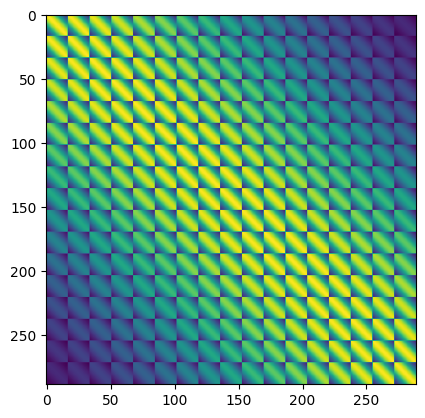

In [68]:
plt.imshow(Cov)

In [81]:
q = np.random.multivariate_normal(mean, Cov, size = 100)
q.shape

(100, 289)

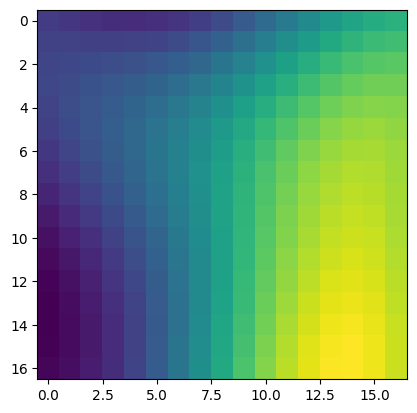

In [86]:
plt.imshow(q[2].reshape(17, 17))

In [88]:
# Save the matrix to a text file
np.savetxt('./data/q_file.txt', q)

# References
1. Solving Bayesian Inverse Problems via Variational Autoencoders, Hwan Goh, Sheroze Sheriffdeen, Jonathan Wittmer, Tan Bui-Thanh, 
https://doi.org/10.48550/arXiv.1912.04212